In [19]:
import sys
sys.path.append("./stable-baselines3-contrib")

import os
import gym
from gym import spaces

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import math
from scipy.stats import unitary_group
import scipy as scp
import networkx as nx
#import torch as th

#from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvStepReturn, VecEnvWrapper
from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps

from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy

from sb3_contrib import RecurrentPPO

In [80]:
#COMMON GATES
H = np.array([[1,1],[1,-1]])/np.sqrt(2)
S = np.array([[1,0],[0,1j]])
Pi8 = np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
sx = np.array([[0,1],[1,0]])
sz = np.array([[1,0],[0,-1]])

#COMMON QUANTUM STATES
q_zero = np.array([[1],[0]])
qubit_plus = H@q_zero

def moving_average(x, w):
    """
    Smooths data x over a window w
    """
    ps = np.repeat(1.0, w) / w
    return np.convolve(x, ps, 'valid')


def plot_results(log_folder, title, w=50):
    """
    Plots learning curve using the log of PPO from stable_baselines3
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, w)
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Steps')
    plt.ylabel('Average Fidelity')
    plt.title(title)
    plt.show()
    
def cnot_ij(i,j,n):
    """
    CNOT gate with 
    i: control qubit
    j: target qubit
    n: number of qubits
    """
    op1,op2,op3,op4 = np.ones(4)
    for k in range(1,n+1):
        if k==i or k==j:
            op1 = np.kron(op1,np.kron(np.array([[1],[0]]).T, np.array([[1],[0]])))
        else:
            op1 = np.kron(op1, np.eye(2))        
        if k == i:
            op2 = np.kron(op2,np.kron(np.array([[1],[0]]).T, np.array([[1],[0]])))
            op3 = np.kron(op3,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
            op4 = np.kron(op4,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
        elif k==j:
            op2 = np.kron(op2,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
            op3 = np.kron(op3,np.kron(np.array([[1],[0]]).T, np.array([[0],[1]])))
            op4 = np.kron(op4,np.kron(np.array([[0],[1]]).T, np.array([[1],[0]])))
        else:
            op2 = np.kron(op2, np.eye(2))
            op3 = np.kron(op3, np.eye(2))
            op4 = np.kron(op4, np.eye(2))

    return op1+op2+op3+op4

class ansatz(gym.Env):
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self, n_qubits, width, graph, flow, output_state, indices_reward=None, noise=0, noise_type="random" ,test_fidelity=False, init_state = None, input_state_indxs = [-1], output_state_indxs=[-1], intermediate_reward=False):
        """
        n_qubits: number of qubits that are measured
        width: width of cluster state
        graph: graph from networkx defining the resource state
        flow: it is a function that defines the flow on the graph
        output_state: output state we want to achieve 
        noise: noise strength
        noise_type: can be "random", "bitflip", or "none"
        test_fidelity: if true, it calculates the fidelity of a circuit with no noise
        init_state = if None, initial state is random, if not None, initial state is init_state
        input_states_indxs = if its [-1], the input state will be located in first (width)-th nodes and will use an
                                extra qubit located in node (width+1). Otherwise, the first (width) elements of the list
                                will correspond to the input state and the (width+1) element to the extra ancilla used.
        output_states_indxs = if its [-1], the output state will be locateed in the last (width)-th nodes. Otherwise. the
                                elements in this list will be the the index of the output state. 
        intermediate_reward = if True, reward is given every step, if False, reward is given only at the end of the measurment pattern
        """
        self.n_qubits = n_qubits
        self.width = width
        if indices_reward is None:
            self.indices_reward = np.arange(width)
        elif indices_reward is not None:
            self.indices_reward = indices_reward
        
        self.graph = graph
        self.flow = flow 
        self.output_state = output_state
        
        self.noise = noise
        self.noise_type = noise_type
        self.test_fidelity = test_fidelity
        self.init_state = init_state 
        self.intermediate_reward = intermediate_reward

        #define action and observation space that is given to the RL agent
        self.action_space = spaces.Box(low = np.array([-1*(np.pi+0.1)]), high=np.array([1*(np.pi+0.1)]) )
        self.observation_space = spaces.Box(low=np.array([0,-np.pi-0.1,0]) , high=np.array([50,np.pi+0.1,1]))
        
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits
        
        
        q_zeros = 1
        for i in range(self.width):
            q_zeros = np.kron(q_zeros,H@q_zero)
        
        if self.init_state is None:
            st = self.pure2density(unitary_group.rvs(2**self.width)@q_zeros)
        elif self.init_state is not None:
            st = self.init_state
        
        #NOISE MODELS
        #--------------------------------------------------------------------------------------------
#         if self.noise_type=="random":
#             noisyU = self.randomUnitary_closetoid(2**self.width,self.noise,20)
#             self.final_qstate_train = self.pure2density(noisyU@self.unitary@(np.conj(noisyU.T))@st)
#         elif self.noise_type=="bitflip":
#             errs = np.random.choice([0,1],p=[1-self.noise, self.noise])
#             if errs==0:
#                 self.final_qstate_train = self.pure2density(self.unitary@st)
#             elif errs==1:
#                 sxs = 1
#                 for i in range(self.width):
#                     sxs = np.kron(sxs, sx)
#                 self.final_qstate_train = self.pure2density(sxs@self.unitary@st)
#         elif self.noise_type=="none":
#             self.final_qstate_train = self.pure2density(self.unitary@st)    
#         #--------------------------------------------------------------------------------------------
        self.final_qstate_train = self.output_state
    
        self.final_qstate_test = self.output_state

        if input_state_indxs == [-1]:
            self.input_state_indices = list(range(self.width+1))
        else:
            self.input_state_indices = input_state_indxs
           
        if output_state_indxs ==[-1]:
            self.output_state_indices = list(range(n_qubits, n_qubits+width))
        else:
            self.output_state_indices = output_state_indxs
            
        assert len(self.input_state_indices)==self.width+1, "ERROR WITH INPUT STATE INDICES"

        subgr = self.graph.subgraph(self.input_state_indices).copy()
        mapping = {nod:idx for idx,nod in enumerate(self.input_state_indices)}
        subgr = nx.relabel_nodes(subgr, mapping)

        self.current_simulated_nodes = np.array(self.input_state_indices)
        self.qstate = self.graph_with_multiple_inputs(subgr, inputstates=st, width=self.width)
        
        
        self.inverse_flow={ }
        for i in range(self.n_qubits):
            if i not in self.input_state_indices[:-1]:
                for j in range(self.n_qubits):
                    if self.flow(j)==i:
                        self.inverse_flow[i] = j
                        break
            else:
                self.inverse_flow[i] = i-self.flow(i)
                
        self.measured_angles={}
        self.measurement_outcomes={}
        for i in self.input_state_indices[:-1]:
            self.measured_angles[self.inverse_flow[i]]=0
            self.measurement_outcomes[self.inverse_flow[i]]=0
        
        self.state = np.array([self.inverse_flow[0], self.measured_angles[self.inverse_flow[0]], self.measurement_outcomes[self.inverse_flow[0]]])
            
    def step(self, action):
        """
        Step function with the convention of the gym library
        It measures the current qubit with an angle of (action)
        """
        
        current_measurement = np.min(self.current_simulated_nodes)
        self.measurements_left -= 1
        
        qubit_to_measure = np.argmin(self.current_simulated_nodes)
        self.qstate, outcome = self.measure_angle(self.qstate, action[0] , qubit_to_measure)

        self.measured_angles[current_measurement] = action[0]
        self.measurement_outcomes[current_measurement] = outcome
                
        
        if outcome == 1:
            fi = self.flow(current_measurement)
            assert fi in self.current_simulated_nodes, "ERROR WITH FLOW"
            modified_qubit  = np.where(np.array(self.current_simulated_nodes)==fi)[0][0]
            self.qstate = self.arbitrary_qubit_gate(sx,modified_qubit,self.width+1)@self.qstate@np.conj(self.arbitrary_qubit_gate(sx,modified_qubit,self.width+1).T)
            
            for ne in self.graph.neighbors(fi):
                if ne in self.current_simulated_nodes and ne!=current_measurement:
                    modified_qubit2  = np.where(np.array(self.current_simulated_nodes)==ne)[0][0]
                    self.qstate = self.arbitrary_qubit_gate(sz,modified_qubit2,self.width+1)@self.qstate@np.conj(self.arbitrary_qubit_gate(sz,modified_qubit2,self.width+1).T)
            


        self.qstate = self.partial_trace(self.qstate, [qubit_to_measure])
        self.current_simulated_nodes = np.delete(self.current_simulated_nodes, np.where(self.current_simulated_nodes==current_measurement))
        #np.setdiff1d(self.current_simulated_nodes, current_measurement)
        
        reward = 0 #fidelity
        
        
        ### INTERMEDIATE STATE FIDELITY
        if self.intermediate_reward:
            if not self.test_fidelity:
                
                reward = self.fidelity(self.final_qstate_train, self.sort_state())
            elif self.test_fidelity:
                reward = self.fidelity(self.final_qstate_test, self.sort_state())

        new_qubit_indx = self.flow(np.min(self.current_simulated_nodes))
        err_temp = False
        if new_qubit_indx in self.current_simulated_nodes:
            err_temp = True
        elif new_qubit_indx in list(self.graph.nodes()):
            self.current_simulated_nodes = np.append(self.current_simulated_nodes, [new_qubit_indx])

        if self.measurements_left!=0:
            next_measured_qubit=np.min(self.current_simulated_nodes)
            self.state = np.array([self.inverse_flow[next_measured_qubit], self.measured_angles[self.inverse_flow[next_measured_qubit]], self.measurement_outcomes[self.inverse_flow[next_measured_qubit]]])
            if err_temp:
                print("ERROR, CHECK FLOW?")
            self.qstate = np.kron(self.qstate, self.pure2density(qubit_plus))
            for ne in self.graph.neighbors(new_qubit_indx):
                if ne in self.current_simulated_nodes:
                    q1 = np.where(self.current_simulated_nodes==ne)[0][0]
                    q2 = np.where(self.current_simulated_nodes==new_qubit_indx)[0][0]
                    #print("q1 and q2:", q1, q2)
                    cgate=self.controlled_z(q1,q2, self.width+1)
                    self.qstate = cgate@self.qstate@np.conj(cgate.T)      
        
        if self.measurements_left == 0:  
            
            self.qstate = self.sort_state()
            if not self.test_fidelity:
                reward = self.fidelity(self.final_qstate_train,self.partial_trace(self.qstate,list(np.delete(np.arange(self.width), self.indices_reward ) )))
            elif self.test_fidelity:
                reward = self.fidelity(self.final_qstate_test, self.partial_trace(self.qstate,list( np.delete(np.arange(self.width), self.indices_reward ) )))
            done = True
        else:
            done = False
        
        info = {}
        
        
        return self.state, reward, done, info
        
        
    def reset(self):
        """
        Resets MDP.
        """               
        self.measured_angles={}
        self.measurement_outcomes={}
        for i in self.input_state_indices[:-1]:
            self.measured_angles[self.inverse_flow[i]]=0
            self.measurement_outcomes[self.inverse_flow[i]]=0
        
        self.state = np.array([self.inverse_flow[0], self.measured_angles[self.inverse_flow[0]], self.measurement_outcomes[self.inverse_flow[0]]])
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits
        
        q_zeros = 1
        for i in range(self.width):
            q_zeros = np.kron(q_zeros, H@q_zero)
        
        if self.init_state is None:
            st = self.pure2density(unitary_group.rvs(2**self.width)@q_zeros)
        elif self.init_state is not None:
            st = self.init_state
        
#         if self.noise_type=="random":
#             noisyU = self.randomUnitary_closetoid(2**self.width,self.noise,20)
#             self.final_qstate_train = self.pure2density(noisyU@self.unitary@(np.conj(noisyU.T))@st)
#         elif self.noise_type=="bitflip":
#             errs = np.random.choice([0,1],p=[1-self.noise, self.noise])
#             if errs==0:
#                 self.final_qstate_train = self.pure2density(self.unitary@st)
#             elif errs==1:
#                 sxs = 1
#                 for i in range(self.width):
#                     sxs = np.kron(sxs, sx)
#                 self.final_qstate_train = self.pure2density(sxs@self.unitary@st)
#         elif self.noise_type=="none":
#             self.final_qstate_train = self.pure2density(self.unitary@st)
        
        self.final_qstate_train = self.output_state
        self.final_qstate_test = self.output_state
        

        subgr = self.graph.subgraph(self.input_state_indices).copy()
        mapping = {nod:idx for idx,nod in enumerate(self.input_state_indices)}
        subgr = nx.relabel_nodes(subgr, mapping)

        self.current_simulated_nodes = np.array(self.input_state_indices)
            
        self.qstate = self.graph_with_multiple_inputs(subgr, inputstates=st, width=self.width)
        
        return self.state
        
    def render(self, mode='human', close=False):
        pass

    def measure_angles(self,angles):
        """
        measures angles
        """
        self.reset()  
        for a in angles:
            state, reward, done, info = self.step([a])
        final_qstate = self.partial_trace(np.copy(self.qstate), list(self.indices_reward))
        final_state = np.copy(self.state)
        
        
        final_outcomes = [value for key, value in self.measurement_outcomes.items() if key>=0]
        
        
        self.reset()
        return final_outcomes, final_qstate, reward
    

    def update_init_state(self, init_state):
        """
        updates initial state
        """
        self.init_state = init_state
        
    def update_output_state(self, out_state):
        self.output_state = out_state
        
    def controlled_z(self, i, j , n):
        """
        Controlled z gate between qubits i and j. 
        n is the total number of qubits
        """
        assert i<n and j<n
        op1, op2 = 1, 2
        for k in range(0,n):
            op1 = np.kron(op1, np.eye(2))
            if k in [i,j]:
                op2 = np.kron(op2, np.kron(np.conjugate(np.array([[0],[1]]).T), np.array([[0],[1]])))
            else:
                op2 = np.kron(op2, np.eye(2))
        return op1-op2

    def fidelity(self, sigma, rho):
        """
        Calculates fidelity between sigma and rho (density matrices)
        """
        srho = linalg.sqrtm(rho)
        prod = srho@sigma@srho
        sprod = linalg.sqrtm(prod)
        return np.abs(np.trace(sprod))

    def pure2density(self, psi):
        """
        Input: quantum state
        Output: corresponding density matrix
        """
        return np.kron(psi, np.conjugate(psi.T))

    def measure_angle(self, rho, angle, i):
        """
        Measures qubit i of state rho with an angle 
        """
        n = self.width+1
        pi0 = 1
        pi1 = 1
        pi0op = np.array([[1, np.exp(-angle*1j)],[np.exp(angle*1j), 1]])/2
        pi1op = np.array([[1,-np.exp(-angle*1j)],[-np.exp(angle*1j), 1]])/2
        for k in range(0,n):
            if k == i:
                pi0 = np.kron(pi0, pi0op)
                pi1 = np.kron(pi1, pi1op)
            else:
                pi0 = np.kron(pi0, np.eye(2))
                pi1 = np.kron(pi1, np.eye(2))
        prob0, prob1 = np.real(np.trace(rho@pi0)), np.real(np.trace(rho@pi1))
        measurement = np.random.choice([0,1], p=[prob0,prob1]/(prob0+prob1))
        
        #FORCE OUTCOME TO BE 0
        measurement = 0
        
        if measurement==0:
            rho = pi0@rho@pi0/prob0
        elif measurement==1:
            rho = pi1@rho@pi1/prob1
            
        return rho, measurement

   
    def partial_trace(self, rho, indices):
        """
        Partial trace of state rho over some indices 
        """
        x,y = rho.shape
        n = int(math.log(x,2))
        r = len(indices)
        sigma = np.zeros((int(x/(2**r)), int(y/(2**r))))
        for m in range(0, 2**r):
            qubits = format(m,'0'+f'{r}'+'b')
            ptrace = 1
            for k in range(0,n):
                if k in indices:
                    idx = indices.index(k)
                    if qubits[idx]=='0':
                        ptrace = np.kron(ptrace, np.array([[1],[0]]))
                    elif qubits[idx]=='1':
                        ptrace = np.kron(ptrace, np.array([[0],[1]]))
                else:
                    ptrace = np.kron(ptrace, np.eye(2))
            sigma = sigma + np.conjugate(ptrace.T)@rho@(ptrace)
        return sigma


    def graph_state(self, G):
        """
        Creates a graph state with graph G
        """
        n = G.number_of_nodes()
        psi = 1
        for i in range(n):
            psi = np.kron(psi, qubit_plus)
        for j in list(G.edges()):
            psi = self.controlled_z(j[0],j[1], n)@psi
        return psi
                                    
                                    
    def graph_with_multiple_inputs(self, G, inputstates=1, width=0):
        """
        Creates a graph state with inputs where G is the graph
        """
        n = G.number_of_nodes()
        psi = 1
        if self.width==0:
            psi = self.pure2density(self.graph_state(G))
        else:
            psi = np.kron(psi, inputstates)
            psi = np.kron(psi, self.pure2density(qubit_plus))

        for j in list(G.edges()):
            psi = self.controlled_z(j[0],j[1], n)@psi@self.controlled_z(j[0],j[1], n)

        return psi 
                                

    def arbitrary_qubit_gate(self,u,i,n):
        """
        Single qubit gate u acting on qubit i
        n is the number of qubits
        """
        op = 1
        for k in range(n):
            if k==i:
                op = np.kron(op, u)
            else:
                op = np.kron(op, np.eye(2))
        return op
    
    def swap_ij(self,i,j,n):
        """
        Swaps qubit i with qubit j
        """
        assert i<n and j<n
        op1,op2,op3,op4 = np.ones(4)
        for k in range(n):
            if k==i or k==j:
                op1 = np.kron(op1,np.kron(np.array([[1],[0]]).T, np.array([[1],[0]])))
                op4 = np.kron(op4,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
            else:
                op1 = np.kron(op1, np.eye(2))
                op4 = np.kron(op4, np.eye(2))

            if k == i:
                op2 = np.kron(op2,np.kron(np.array([[1],[0]]).T, np.array([[0],[1]])))
                op3 = np.kron(op3,np.kron(np.array([[0],[1]]).T, np.array([[1],[0]])))
            elif k==j:
                op2 = np.kron(op2,np.kron(np.array([[0],[1]]).T, np.array([[1],[0]])))
                op3 = np.kron(op3,np.kron(np.array([[1],[0]]).T, np.array([[0],[1]])))
            else:
                op2 = np.kron(op2, np.eye(2))
                op3 = np.kron(op3, np.eye(2))
        return op1+op2+op3+op4
    
    def brownian_circuit(self,dim, n, dt):
        u = np.eye(dim)
        for j in range(n):
            re = np.random.normal(size=(dim,dim))
            im = 1j*np.random.normal(size=(dim,dim))
            c = re + im
            h = (c+np.conj(c.T))/4
            u = u@scp.linalg.expm(1j*h*dt)
        return u

    def randomUnitary_closetoid(self,dim, t, n):
        return self.brownian_circuit(dim,n, np.sqrt(1/(n*dim))*2*np.pi*t)
    
    
    def sort_state(self):
        sorted_state = self.qstate.copy()
        sorted_nodes = self.current_simulated_nodes.copy()
        sorted_nodes.sort()
        if (self.current_simulated_nodes==sorted_nodes).all():
            pass
        else:
            sim_nodes = self.current_simulated_nodes.copy()
            for n_iteret in range(1,len(sim_nodes)):
                ll = np.argmin(sim_nodes[:-n_iteret])
                sim_nodes[n_iteret], sim_nodes[ll+n_iteret] =sim_nodes[ll+n_iteret], sim_nodes[n_iteret]  
                #print("ll+n_iteret-1:", ll+n_iteret-1, "\nn_iteret:", n_iteret, "\nlensimnodes", len(sim_nodes))
                swapgate = self.swap_ij(ll+n_iteret-1,n_iteret,len(sim_nodes))
                sorted_state =swapgate@sorted_state@np.conj(swapgate.T)
        return sorted_state


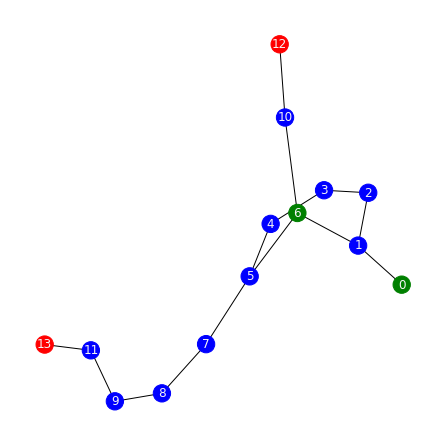

In [81]:
#Define graph topology
gr = nx.Graph()
gr.add_nodes_from(list(range(14)))
gr.add_edges_from([(0, 1), (1, 2), (2,3), (3,4),(4,5),
                   (6,1),(6,5),(6,10),(10,12),(5,7),(7,8),(8,9),(9,11),(11,13)])

#plots graph state
fig = plt.figure(1, figsize=(6, 6))
xpp = nx.spring_layout(gr)
color_map = []
for node in gr:
    if node in [0,6]:
        color_map.append('green')
    elif node in [12,13]:
        color_map.append('red')
    else: 
        color_map.append('blue')
nx.draw(gr,node_color=color_map, with_labels = True,font_color="whitesmoke")
plt.axis('off');

In [82]:
#Define flow on graph gr
def flow_function(i):
    output = 0
    if i==6:output=10
    elif i in [5,9,10,11]: output=i+2
    else: output = i+1
    return output

def pure2density(psi):
    """
    Input: quantum state
    Output: corresponding density matrix
    """
    return np.kron(psi, np.conjugate(psi.T))

In [83]:
ansatz_state = ansatz(12, 2, gr, flow_function, pure2density(np.kron(qubit_plus,1)), indices_reward=[0], noise=0, noise_type="none" ,init_state=None,test_fidelity=False,  input_state_indxs = [6,0,1])


In [84]:
ansatz_state.measure_angles(np.random.rand(12))[1]

array([[0.10433705-3.16654797e-17j, 0.11448434-2.23623908e-01j],
       [0.11448434+2.23623908e-01j, 0.89566295+3.78386558e-17j]])

In [95]:
#COMMON GATES
H = np.array([[1,1],[1,-1]])/np.sqrt(2)
S = np.array([[1,0],[0,1j]])
Pi8 = np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
sx = np.array([[0,1],[1,0]])
sz = np.array([[1,0],[0,-1]])

#COMMON QUANTUM STATES
q_zero = np.array([[1],[0]])
qubit_plus = H@q_zero

class env_ansatz_qrnn(gym.Env):
    
    def __init__(self,num_layers, n_qubits, width, graph, flow, training_data_time,g=lambda x: x,indices_reward=[0], noise=0, noise_type="random" ,test_fidelity=False, input_state_indxs = [-1], output_state_indxs=[-1], intermediate_reward=False):
        """
        xxxxx
        """
        self.num_envs=n_qubits
        assert len(training_data_time)>=num_layers, "NOT ENOUGH DATA POINTS"
        self.g = g
        self.n_qubits = n_qubits
        self.training_data_time = training_data_time
        training_data = self.training_states(2*np.pi*np.random.rand()*np.ones(len(training_data_time)), self.training_data_time, g=g) 
        
        self.training_data = training_data
        
        self.input_state = np.kron(self.pure2density(q_zero), self.training_data[0][0])
        self.last_output_state = self.pure2density(q_zero)
        self.ansatz_state = ansatz(n_qubits, width, graph, flow, self.training_data[1][0], indices_reward=indices_reward, init_state = self.input_state, noise=noise, noise_type=noise_type ,test_fidelity=test_fidelity, input_state_indxs = input_state_indxs, output_state_indxs=input_state_indxs, intermediate_reward=intermediate_reward)
        self.num_layers = num_layers
        self.current_layer = 0
        
        self.action_space = spaces.Box(low = -(np.pi+0.1)*np.ones(n_qubits), high= (np.pi+0.1)*np.ones(n_qubits) )
        #self.observation_space = spaces.Box(low=np.concatenate( ([-1],-1*np.ones(n_qubits)) ) , high=np.concatenate( ([50], np.ones(n_qubits)) ))
        self.observation_space = spaces.Box(low=np.array([-1]) , high=np.array([50]))
        
        #self.state = np.zeros(n_qubits+1)
        self.state = np.zeros(1)
        
    def measure_angles(self,angles):
        output_state, output_qstate, reward = self.ansatz_state.measure_angles(angles)
        return output_state, output_qstate, reward
    
    def step(self,angles):
        info = {}
        done = False
        reward = 0
        self.input_state = np.kron(self.last_output_state, self.training_data[0][self.current_layer])
        self.ansatz_state.update_init_state(self.input_state)
        self.ansatz_state.update_output_state(self.training_data[1][self.current_layer])
        output_outcomes, output_qstate, reward = self.measure_angles(angles)
        self.last_output_state = output_qstate
        
        #self.state = np.array([self.current_layer]+list(output_outcomes))
        self.state = np.array([self.current_layer])
        
        self.current_layer +=1

        if self.current_layer==self.num_layers:
            done = True
        
        return self.state, reward/self.num_layers, done, info
    
    
    def reset(self):
        training_data_r = self.training_states(2*np.pi*np.random.rand()*np.ones(len(self.training_data_time)), self.training_data_time, g=self.g) 
        self.training_data = training_data_r
        
        self.input_state = np.kron(self.pure2density(q_zero), self.training_data[0][0])
        self.last_output_state = self.pure2density(q_zero)
        self.ansatz_state.reset()
        
        self.current_layer = 0
        #self.state = np.zeros(self.n_qubits+1)
        self.state= np.zeros(1)
        return self.state
        
    def render(self, mode='human', close=False):
        pass
    
    def pure2density(self,psi):
        """
        Input: quantum state
        Output: corresponding density matrix
        """
        return np.kron(psi, np.conjugate(psi.T))
    
    
    def training_states(self,phis, times, g=lambda x: x):
        """
        creates training data
        """
        predrift = []
        postdrift = []

        def rotgate(phi):
            return np.array([[1,0],[0,np.exp(1j*phi)]])

        for ph,t in zip(phis,times):
            predrift.append(self.pure2density(rotgate(ph)@qubit_plus))
            postdrift.append(self.pure2density(rotgate(ph-g(t))@qubit_plus))
        return predrift, postdrift

# Drift Constant Speed (RNN with n+1 entries)

In [86]:
env = env_ansatz_qrnn(4, 12, 2, gr, flow_function, [0,1,2,3],g=lambda x: np.sqrt(x), input_state_indxs = [6,0,1], indices_reward=[0])

In [87]:
log_dir = "./logs/logs1"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [88]:
model = RecurrentPPO("MlpLstmPolicy", env)
model.learn(total_timesteps=int(1e5), callback=event_callback)

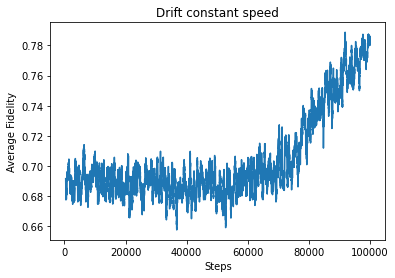

In [90]:
#plot learning curve of the agent
plot_results(log_dir, title="Drift constant speed",w=100)

## RNN with 1 entry

In [96]:
env = env_ansatz_qrnn(4, 12, 2, gr, flow_function, [0,1,2,3],g=lambda x: np.sqrt(x), input_state_indxs = [6,0,1], indices_reward=[0])

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [97]:
log_dir = "./logs/logs1"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [98]:
model = RecurrentPPO("MlpLstmPolicy", env)
model.learn(total_timesteps=int(1e5), callback=event_callback)

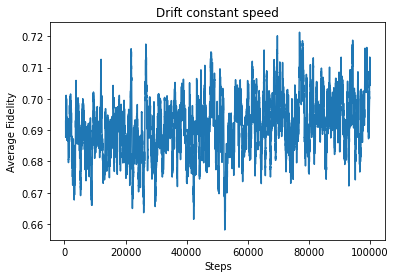

In [99]:
#plot learning curve of the agent
plot_results(log_dir, title="Drift constant speed",w=100)

# Drift Varying Speed (RNN with n+1 entries)

In [91]:
vk = [3,5,7,8]
env = env_ansatz_qrnn(4, 12, 2, gr, flow_function, [0,1,2,3],g=lambda x: np.sqrt(x)*vk[x], input_state_indxs = [6,0,1], indices_reward=[0])

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [92]:
log_dir = "./logs/logs2"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [93]:
model = RecurrentPPO("MlpLstmPolicy", env)
model.learn(total_timesteps=int(1e5), callback=event_callback)

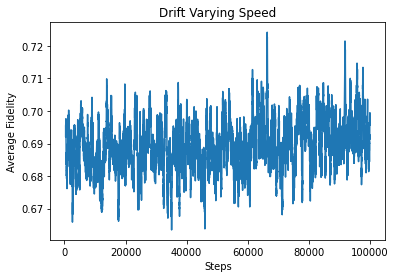

In [94]:
#plot learning curve of the agent
plot_results(log_dir, title="Drift Varying Speed",w=100)

## RNN with 1 entry

In [100]:
vk = [3,5,7,8]
env = env_ansatz_qrnn(4, 12, 2, gr, flow_function, [0,1,2,3],g=lambda x: np.sqrt(x)*vk[x], input_state_indxs = [6,0,1], indices_reward=[0])

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [101]:
log_dir = "./logs/logs2"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [102]:
model = RecurrentPPO("MlpLstmPolicy", env)
model.learn(total_timesteps=int(1e5), callback=event_callback)

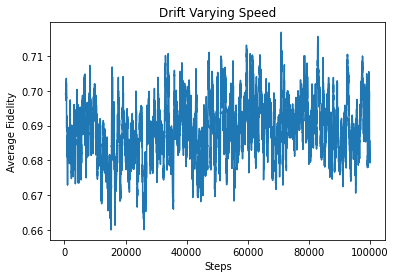

In [103]:
#plot learning curve of the agent
plot_results(log_dir, title="Drift Varying Speed",w=100)

# Delay Channel

# Input Averaging

# All together! : Filter with band window 

# NORMAL SUPERVISED LEARNING